In [17]:
import os
import cv2
import numpy as np
from tqdm import tqdm

REBUILD_DATA = False

class DogsVsCats():
    IMG_SIZE = 50
    CATS = "dogs-vs-cats/Cat"
    DOGS = "dogs-vs-cats/Dog"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []
    catcount = 0
    dogcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    if label==self.CATS:
                        self.catcount+=1
                    elif label==self.DOGS:
                        self.dogcount+=1
                except Exception as e:
                    pass
                    
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print(f"Cats: {self.catcount}")
        print(f"Dogs: {self.dogcount}")

if REBUILD_DATA:
    dogsvcats = DogsVsCats()
    dogsvcats.make_training_data()

  0%|          | 62/12500 [00:00<00:20, 616.94it/s]

dogs-vs-cats/Cat


  1%|          | 77/12500 [00:00<00:16, 766.87it/s]

dogs-vs-cats/Dog


100%|██████████| 12500/12500 [00:16<00:00, 775.21it/s]


Cats: 12476
Dogs: 12470


In [18]:
training_data = np.load("training_data.npy", allow_pickle=True)

In [23]:
print(len(training_data))
training_data[0][0].shape

24946


(50, 50)

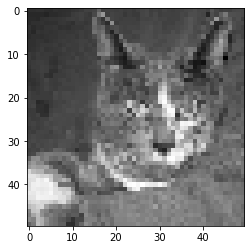

In [20]:
import matplotlib.pyplot as plt
plt.imshow(training_data[0][0], cmap="gray")
plt.show()

In [102]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [137]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        
        self.fc1 = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, 2)
        
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2,2))
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, (2,2))
        
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, (2,2))
        
        x = torch.flatten(x, start_dim=1) 
        x = F.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=1)
        return x
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [138]:
net.forward(torch.randn([2, 1, 50, 50]))

tensor([[0.4950, 0.5050],
        [0.4969, 0.5031]], grad_fn=<SoftmaxBackward>)

In [139]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=1e-3)
loss_function = nn.BCELoss()

X = torch.Tensor([i[0] for i in training_data]).view((-1, 50, 50))
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)

In [140]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

22452
2494


In [141]:
BATCH_SIZE = 64
EPOCHS = 3

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]
        net.zero_grad()
        outputs = net.forward(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()

100%|██████████| 351/351 [00:52<00:00,  6.64it/s]


In [142]:
correct = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net.forward(test_X[i].view(-1, 1, 50, 50))[0]
        predicted = torch.argmax(net_out)
        if predicted==real_class:
            correct+=1
print(f"Accuracy: {correct/len(test_X):.2f}")

100%|██████████| 2494/2494 [00:05<00:00, 425.43it/s]

Accuracy: 0.80
